In [1]:
import sympy as sy
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
%matplotlib inline

# Gradients of expectations


- https://gregorygundersen.com/blog/2018/04/29/reparameterization/
- https://ermongroup.github.io/cs228-notes/
- https://ermongroup.github.io/cs228-notes/extras/vae/
- https://stats.stackexchange.com/questions/199605/how-does-the-reparameterization-trick-for-vaes-work-and-why-is-it-important
- https://jaan.io/what-is-variational-autoencoder-vae-tutorial/
- https://gabrielhuang.gitbooks.io/machine-learning/content/reparametrization-trick.html
- https://arxiv.org/pdf/1606.05908.pdf

**OUR GOAL**: We want to maximize an expectation of a function with respect to a probability distribution

**OUR PLAN**: Obtain the gradient of the expectation and minimize


## Computing an expectation

recall the montecarlo aproximation of an expectation

$$
\begin{align}
\mathbb{E}_{z\sim p(z)} \big[f(z)\big] &= \int_0^\infty p(z)f(z) dz & (1)\\
&\approx \frac{1}{N}\sum_{z_i \sim p(z)}^N f(z_i)  & (2)
\end{align}
$$

we check it with an exponential distribution, and any $f(z)$:

- $z \in [0, \infty]$
- $p(z) = \lambda e^{-\lambda z}$

In [2]:
l, z = sy.symbols("l z")                       # symbols
ln  = .24                                        # a numerical value for lambda

p  = l*sy.exp(-l*z)                            # symbolic analytical pdf
pn = sy.lambdify(z, p.subs({l: ln}), "numpy")  # evaluable pdf
ps = stats.expon(loc=0, scale=1/ln)            # equivalent scipy.stats object

f  = sy.sin(z)                                 # any function (symbolic)
fn = sy.lambdify(z, f, "numpy")                # evaluable



In [3]:
# the symbolic pdf and stats pdf are equivalent
zs = np.linspace(0,100,1000)
np.linalg.norm(pn(zs) - ps.pdf(zs)) # must be zero

1.06065543451462e-16

compute eq (1) above

In [4]:
expectation_integral = sy.integrate(p.subs({l: ln})*f, z)
expectation_integral = expectation_integral.subs({z:1e100}) - expectation_integral.subs({z:0})
expectation_integral

0.226928895612708

montecarlo approximation as eq (2) above

In [5]:
zs = ps.rvs(10000)
np.mean(fn(zs))

0.21836961424382206

## Computing an expectation of a parametrized function

Let's have $f(z)$ depending on a parameter $\theta$, and we denote it with $f_\theta(z)$ to emphasize it, for instance


In [6]:
t = sy.symbols(r"\theta")
f = -(t+(t-2)**2)*sy.sin(z)
f


(-\theta - (\theta - 2)**2)*sin(z)

the above expectation will naturally become a function of $\theta$

$$
\begin{align}
\mathbb{E}_{z\sim p(z)} \big[f_\theta(z)\big] &= \int p(z)f_\theta(z) dz \\
&\approx \frac{1}{N}\sum_{z_i \sim p(z)}^N f_\theta(z_i)  & (2)
\end{align}
$$

In [7]:
expectation_integral = sy.integrate(p.subs({l: ln})*f, z)
expectation_integral = expectation_integral.subs({z:1e100}) - expectation_integral.subs({z:0})
expectation_integral

-0.226928895612708*\theta - 0.226928895612708*(\theta - 2)**2

observe how the value of the expectation depends on the parameter $\theta$ (and the probability $p(z)$)

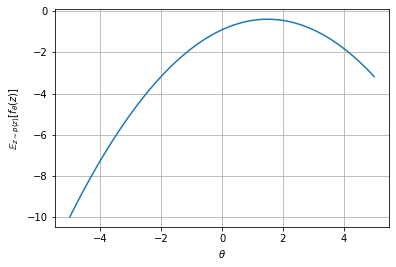

In [8]:
t_range = np.linspace(-5,5,100)
expectation_integral_fn = sy.lambdify(t, expectation_integral, "numpy")

plt.plot(t_range, expectation_integral_fn(t_range))
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\mathbb{E}_{z\sim p(z)} [f_\theta(z)] $");
plt.grid();

which we can evaluate for a specific value of $\theta$, directly on the analytic integral, or with the montecarlo simulation

In [9]:
t_val = -2
sy.N(expectation_integral.subs({t: t_val }))

-3.17700453857791

In [10]:
fn = sy.lambdify(z, f.subs({t: t_val}), "numpy")
np.mean(fn(zs))

-3.057174599413509

## Computing the gradient of an expectation

so we can ask for its gradient (which must be with respect to the parameter $\theta$).

The gradient naturally slips into the integral, or the montecarlo approximation sum (the derivative of a sum is the sum of the derivatives)

$$
\begin{align}
\nabla_\theta \mathbb{E}_{p_z(z)}[f_\theta(z)] &= \nabla_\theta \Big[\int p_z(z) f_\theta(z)dz\Big]\\
&= \int \nabla_\theta \Big[ p_z(z) f_\theta(z)\Big] dz \\
&= \int p_z(z) \nabla_\theta \Big[ f_\theta(z)\Big] dz &\;\;\;\;\;(1)
\end{align}
$$

$$
\begin{align}
\nabla_\theta \mathbb{E}_{p_z(z)}[f_\theta(z)] &\approx \nabla_\theta \Big[ \frac{1}{N}\sum_{z_i \sim p(z)}^N f_\theta(z_i) \Big] & &\;\;\;\;\;(2)\\
&=   \frac{1}{N}\sum_{z_i \sim p(z)}^N \nabla_\theta f_\theta(z_i)  & &\;\;\;\;\;(3)\\
\end{align}
$$

**OBSERVATIONS**

- We can take $p_z(z)$ out of $\nabla_\theta$ in $(1)$ because $p_z(z)$ does not depend on $\theta$ so it appears as a constant for $\nabla_\theta$

- Eqs $(1)$ and $(3)$ show that the gradient of this expectation is equal to the expectation of the gradient

- Regularly, in ML, a loss function is defined in terms of each data point in a mini-batch and then averaged:

$$\mathcal{L}_\theta = \frac{1}{N}\sum_i^N l_\theta(x^{(i)})$$

where $\theta$ are the model parameters. We then use the gradient of the loss function to optimize

$$\nabla_\theta \mathcal {L}_\theta = \frac{1}{N}\sum_i^N \nabla_\theta l_\theta(x^{(i)})$$

which is analogous to eq. $(3)$ except that we are not explicitly sampling from a known or target distribution, but using the samples on the dataset available. So **what we are doing is not specially new**.


In [11]:
df = f.diff(t)
df

(3 - 2*\theta)*sin(z)

In [12]:
# equation (1)
grad_expectation_integral = sy.integrate(p.subs({l: ln})*df, z)
grad_expectation_integral = grad_expectation_integral.subs({z:1e100}) - grad_expectation_integral.subs({z:0})
grad_expectation_integral

0.680786686838124 - 0.453857791225416*\theta

In [13]:
sy.N(grad_expectation_integral.subs({t: t_val }))

1.58850226928896

In [14]:
# equation (2), takes a long time, since it must differentiate a long sum (one term per sample)
sum([f.subs({z:zi}) for zi in zs]).diff(t).subs({t: t_val})/len(zs)

1.52858729970676

In [15]:
# equation (3) 
dfn = sy.lambdify(z, df.subs({t: t_val}), "numpy")
np.mean(dfn(zs))

1.5285872997067544

## Maximizing the expectation

since we have a gradient we can get the maximum (in this simple case, we can solving analyticaly, we do not need gradient descent/ascent)

In [16]:
t_max = sy.solve(grad_expectation_integral, t)[0]
t_max

1.50000000000000

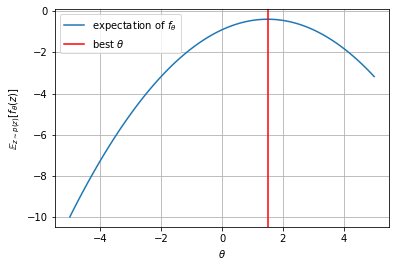

In [17]:
plt.plot(t_range, expectation_integral_fn(t_range), label=r"expectation of $f_\theta$")
plt.axvline(t_max, color="red", label=r"best $\theta$")
plt.grid();
plt.legend();
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\mathbb{E}_{z\sim p(z)} [f_\theta(z)] $");

### Now, $p(z)$ is also parametrized by $\theta$

In [72]:
expectation_integral = sy.integrate(p.subs({l: t/100})*f, z)
expectation_integral = expectation_integral.subs({z:1e100}) - expectation_integral.subs({z:0})
expectation_integral

\theta*(-\theta - (\theta - 2)**2)*Piecewise((-1.90318865502514e+99*exp(1.0e+100*I) + 4.62362119375967e+99*I*exp(1.0e+100*I), Eq(\theta, -100*I)), (-4.62362119375967e+99*I*exp(-1.0e+100*I) - 1.90318865502514e+99*exp(-1.0e+100*I), Eq(\theta, 100*I)), (38.0637731005029*\theta/(\theta**2*exp(1.0e+98*\theta) + 10000*exp(1.0e+98*\theta)) - 9247.24238751934/(\theta**2*exp(1.0e+98*\theta) + 10000*exp(1.0e+98*\theta)), True))/100 + 100*\theta*(-\theta - (\theta - 2)**2)/(\theta**2 + 10000)

<lambdifygenerated-34>:2: RuntimeWarning: overflow encountered in exp
  return (-Dummy_3895 - (Dummy_3895 - 2)**2)*(sin(Dummy_3895) + 2)*select([equal(Dummy_3895, -arcsin(2 - 1j)),equal(Dummy_3895, -arcsin(2 + 1j)),True], [-4.62362119375967e+99*1j*exp(-1.0e+100*1j) - 1.90318865502514e+99*exp(-1.0e+100*1j),-1.90318865502514e+99*exp(1.0e+100*1j) + 4.62362119375967e+99*1j*exp(1.0e+100*1j),0.380637731005029*sin(Dummy_3895)/(2.50200547715522e+8685889638065036691153335483872363697502844730539815810306297047445974888969453981804292560091717209*exp(1.0e+100*sin(Dummy_3895))*sin(Dummy_3895)**2 + 1.00080219086209e+8685889638065036691153335483872363697502844730539815810306297047445974888969453981804292560091717210*exp(1.0e+100*sin(Dummy_3895))*sin(Dummy_3895) + 1.25100273857761e+8685889638065036691153335483872363697502844730539815810306297047445974888969453981804292560091717210*exp(1.0e+100*sin(Dummy_3895))) - 0.163448776741876/(2.50200547715522e+86858896380650366911533354838723636975028447305398

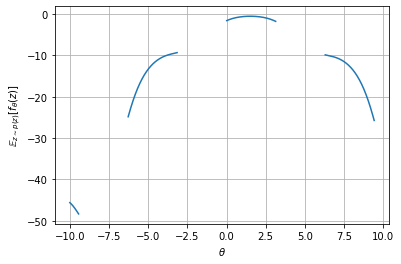

In [71]:
t_range = np.linspace(-10,10,1000)
expectation_integral_fn = sy.lambdify(t, expectation_integral, "numpy")

plt.plot(t_range, expectation_integral_fn(t_range))
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\mathbb{E}_{z\sim p(z)} [f_\theta(z)] $");
plt.grid();